# A coastal flooding study: prediction & sensitivity analysis

Metamodeling course.
O. Roustant, October 2024.

Data kindly provided by the BRGM

*Rohmer, J., Idier, D., Paris, F., Pedreros, R., Louisor, J. (2018). Casting light on forcing and breaching scenarios that lead to marine inundation: Combining numerical simulations with a random forest classification approach. Environmental Modelling & Software, 104, p. 64-80*

We consider the problem of prediction the water height at the site "les Boucholeurs", in the west French coast, given 5 input variables representing weather and earth conditions. 

The dataset is composed of 500 flooding maps composed of 194 x 202 pixels, obtained with a design of experiment (DoE) of the 5 input variables. At each pixel, we measure the water height. In addition, for each map, we know the total flooded area. Such maps have been obtained with a time-consuming simulator (1 run $\approx$ 30 minutes to 1 hour). The aim is twofold: 1) to predict a water map for a new configuration in real-time, thus without running the simulator. 2) to quantify the influence of the inputs on water heights, in case of flooding.

For simplicity, we will focus on the subset of data for which there has been flooding, in the sense that the flooding area is non zero, corresponding to 243 maps (see after). The global scheme is the following:
* Split the dataset in a training set Xtrain and a test set Xtest
* PCA encoding: use a PCA analysis to reduce dimension, based on the training set Xtrain
* Create a metamodel on selected principal components, with Xtrain
* Predict the value of the principal components on the test set Xtest
* PCA decoding: reconstitue the map with the PCA eigenvectors

The global sensitivity analysis (GSA) will be done on each principal component. Furthermore, a generalized Sobol index can be defined with the formula:
$$ GSI_I = \frac{\sum_{j = 1}^p \lambda_j S^{(j)}_I}{\sum_{j=1}^p \lambda_j} $$
where $I \subseteq \{1, \dots, d\}$ is a subset of variables, $S^{(j)}_I$ is the corresponding Sobol index of the $j^\textrm{th}$ principal component, and $\lambda_j$ is the $j^\textrm{th}$ eigenvalue. 

Here is a brief explanation of the 5 inputs variables: 
* Tide (amplitude de la marée), $T \in [0.95m,3.70m]$
* Surge (pic de surcote), $S \in [0.65m,2m]$
* $t_0$ ou $phio$ (Différence de phase entre le pic de surcote et l’amplitude de la marée), phio $\in [-6h, 6h]$
* $tm$ ou $t-$ (Durée de la diminution de la surcote), $tm \in [0.5h, 12h]$
* $tM$ ou $t+$ (Durée d'augmentation de la surcote), $tM \in [0.5h, 12h]$

Notice that in the dataset, all the input variables have been rescaled to lie in the interval $[0, 1]$.
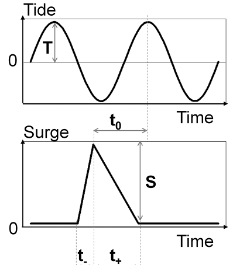

# Questions

1. Load the data and visualize the design of experiments. What kind of design is it? Can you identify it precisely? We color the points whether Area is > 0 (flooding) or not. Can you interpret the flooding zone?

From now on, we now work on the design points for which there is flooding. We split the data into train and test sets. For the training set, we create XtrainSet, a matrix of size nTrain x d, and YtrainSet an array containing the images, considered as vectors in dimension D = number of pixels. Idem for the test set.

2. Visualize the maps of the training set corresponding to the given subsample of 4 design points (and check that there is indeed a flooding in some zone).  

3. Do a principal components analysis (PCA) on the training set, without scaling the data (here it seems to work better). How many principal components seem useful? How should we select them in a machine learning framework (we will not do it here)? Visualize the first four principal components (PCs) as a map. Interpret them by remembering that a PC is a linear combination of the original variables.

4. We provide a PCA encoder that takes a map (viewed as a vector in dimension D) and builds all principal components. Similarly, we provide a PCA decoder that takes a number of PCs and reconstitute the map (the vector in dimension D). For verification, choose a map. Apply the PCA encoder, and the PCA decoder with $n_{PC} = 10$ PCs. Check that you reconstitue well the original map.

5. Estimate a kriging (= GP) model for each of the first 10 PCs. What kernel is used by default? Recall why we must use a $\texttt{multistart}$ in the hyperparameter estimation (here choose $\texttt{multistart = 50}$). Consider the 1st PC. Look at the estimated coefficients of the kernel, and explain why we can detect here the most influential variables. Study the validity of the model (function 'plot'). What's happening for the PC with order $\geq 4$? Is it a problem for the final prediction?

6. Compute the predictions on the test set, by computing the predictions of each GP and use the PCA decoder.  Choose a map of the test set. Visualize the predicted map and compare. We visualize the spatial errors over all the test set $T$, defined by
$$ \text{RMSE} = \left( \frac{1}{\vert T \vert} \sum_{i \in T} \Vert Y_i - \hat{Y}_i \Vert^2 \right)^{1/2}$$
where $Y_i$ is a map (D dim. vector) and $\hat{Y}_i$ is the predicted map. Comment the results.
We also compute the $Q^2$ criterion defined by
$$ Q^2 = 1 - \sum_{i \in T} \frac{\Vert Y_i - \hat{Y}_i \Vert^2}{\Vert Y_i - \bar{Y} \Vert^2}$$
where $\bar{Y}$ is the 'mean map' obtained by averaging over all maps (in the test set). Thus the $Q^2$ is equal to 1 if the prediction is perfect, 0 if it is as good as the mean, negative if worse.

Let us now perform a global sensitivity analysis (GSA). We assume that the 5 input variables are uniform and independent on $[0, 1]$. 

7. Let us consider the first PC. We do a GSA on the kriging mean. Estimate numerically the Sobol indices and total indices, using the function $\texttt{soboljansen}$ (R package $\texttt{sensitivity}$). What are the most influential inputs? The inactive ones? Are there interactions? Between which variables? Why can we deduce that there are no interactions of order 4 or 5 here? Same questions for the second PC.

8. To go further into details, estimate all the interactions up to order 3, using the functions $\texttt{sobol}$. Check that we do not miss higher order interaction terms, and explain how the results are consistent with the total effects estimated in the previous question. Same question for the second PC.

9. Compute the generalized sensitivity indices by considering the Sobol indices (including interactions up to order 3) of the first 3 PCs.

10. Consider again the first PC. We give a code to estimate the conditional mean of the toy function Ishigami. Adapt this code to visualize the main effects of the first PC for all the 5 input variables.

11. Assumption criticism. In the metamodeling phase, we have modeled *independently* each PC by a GP. Is this assumption justified here? Similarly, in the sensitivity analysis phase, we have assumed all input variables independent and uniform. Is this assumption correct?



# Starter

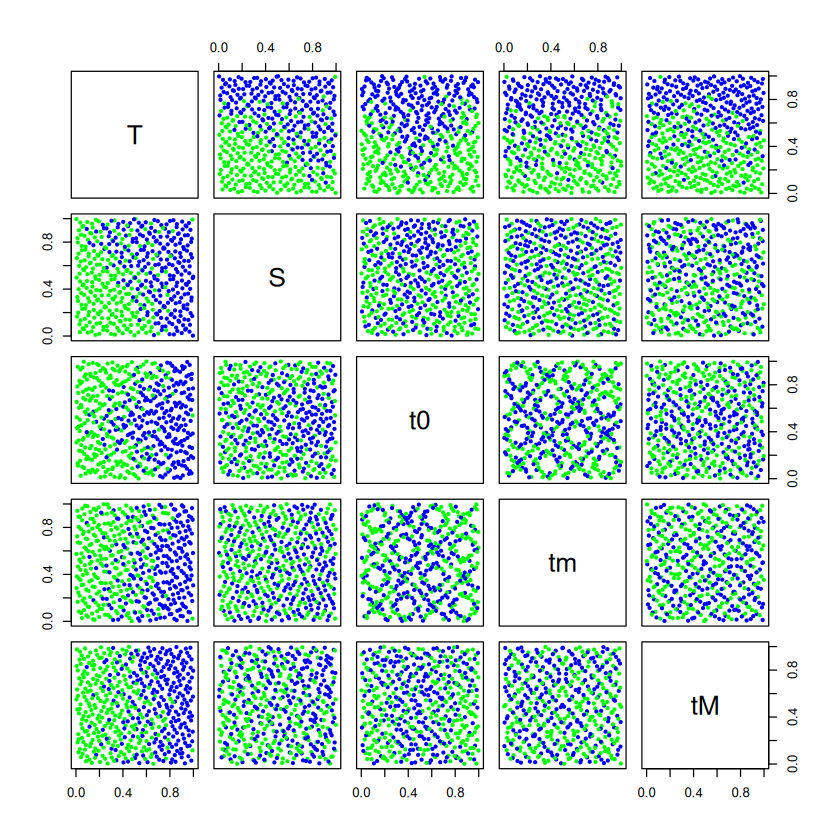

In [9]:
# Question 1 - Data loading and DoE 
rm(list = ls())
load("Boucholeurs_NOFailure.RData")

names(doe) <- c("T", "S", "t0", "tm", "tM") # shorter names

doeFull <- doe
HEFull <- HE

# design of experiments, with/without flooding
options(repr.plot.width = 7, repr.plot.height = 7)
pairs(doeFull, pch = 19, cex = 0.5,
      xlim = c(0, 1), ylim = c(0, 1),
      col = ifelse(Area > 0, "blue", "green"))

### **ANSWER :**

This is a scatterplot matrix. We can see for example that a great tide and a great surge is a critical case for flooding. Generally speaking, floods occur mostly at high tide and high stride. We note that a t0 of ‘average’ time, meaning that we have a high low tide (a low tide of above-average height) seems also symptomatic of a flood. On the other hand, the tm and Tm parameters do not seem to have much influence on whether there is flooding or not.

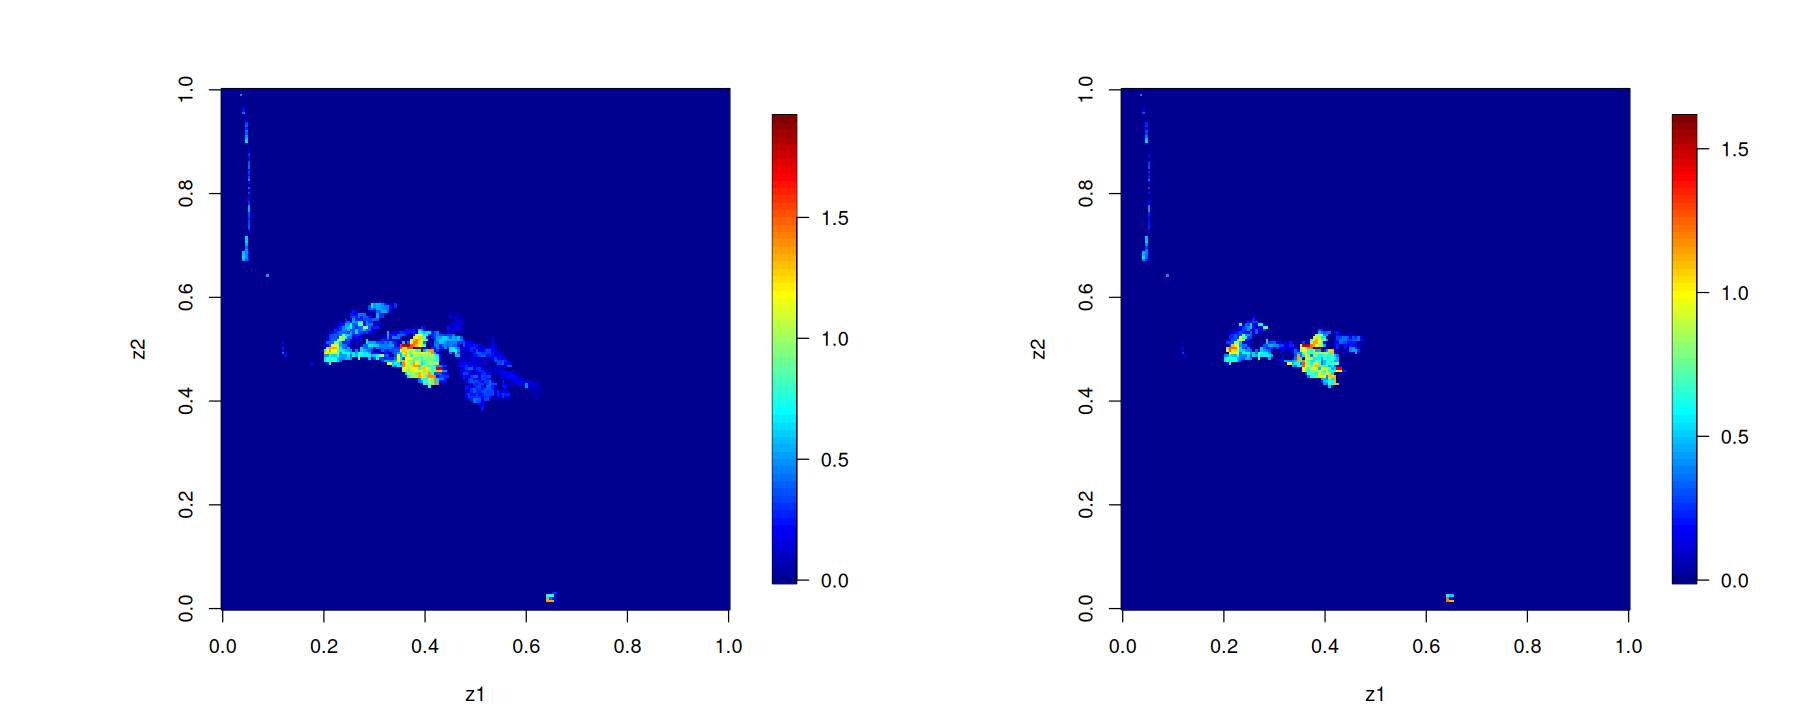

In [10]:
# In the sequel, we consider the subset of the DoE for which there has been flooding
inondOnly <- which(Area > 0)
doe <- doeFull[inondOnly, ]
HE <- HEFull[, , inondOnly]

# Utilities and maps visualization
# Map visualizations.
library(fields)

nGridx <- dim(HE)[1]
nGridy <- dim(HE)[2]

map2vec <- function(map){ 
  as.numeric(map) 
}
vec2map <- function(vec, nx = nGridx, ny = nGridy){ 
  matrix(vec, nrow = nx, ncol = ny)
}

z1 <- seq(from = 0, to = 1, length = nGridx)
z2 <- seq(from = 0, to = 1, length = nGridy)

par(mfrow = c(1, 2))
options(repr.plot.width = 15, repr.plot.height = 6)
for (i in 1:2){
  image.plot(z1, z2, HE[,,i], graphics.reset = TRUE)
}

In [11]:
# train and test set
n <- nrow(doe)
nTrain <- 150
nTest <- n - nTrain
set.seed(0)
indTrain <- sample(1:n, size = nTrain)
indTest <- setdiff(1:n, indTrain)

Xtrain <- doe[indTrain, ]
Xtest <- doe[-indTrain, ]

YtrainSet <- matrix(NA, nrow = nTrain, ncol = nGridx * nGridy)
YtestSet <- matrix(NA, nrow = nTest, ncol = nGridx * nGridy)

for (i in 1:nTrain){
  YtrainSet[i, ] <- map2vec(HE[, , indTrain[i]])
}
for (i in 1:nTest){
  YtestSet[i, ] <- map2vec(HE[, , indTest[i]])
}


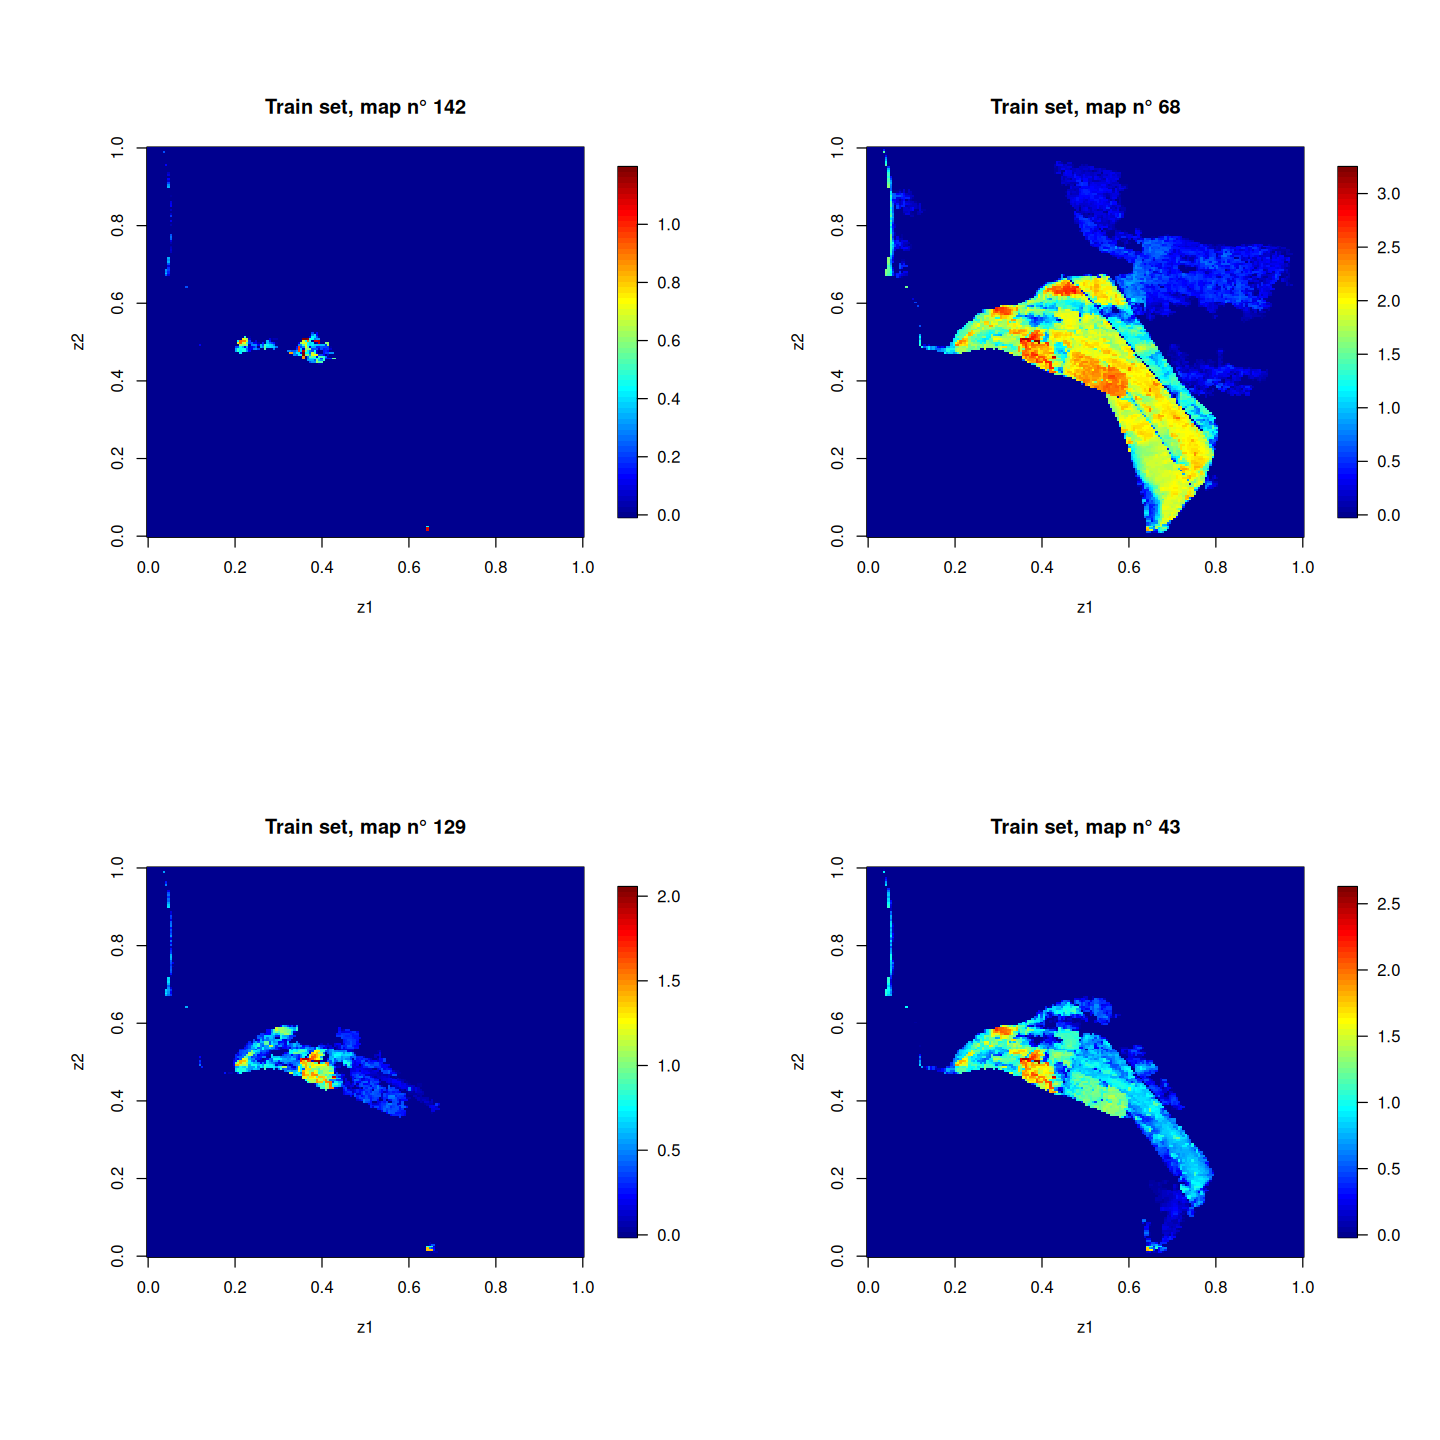

In [12]:
# Question 2
set.seed(0)
subsample <- sample(1:nTrain, 4)

par(mfrow = c(2, 2))
options(repr.plot.width = 12, repr.plot.height = 12)
for (i in 1:4){
  j <- subsample[i]
  image.plot(z1, z2, vec2map(YtrainSet[j, ]),    # map of the training set n°j
             main = paste("Train set, map n°", j),
             graphics.reset = TRUE)
}


In [13]:
resPCA

ERROR: Error in eval(expr, envir, enclos): objet 'resPCA' introuvable


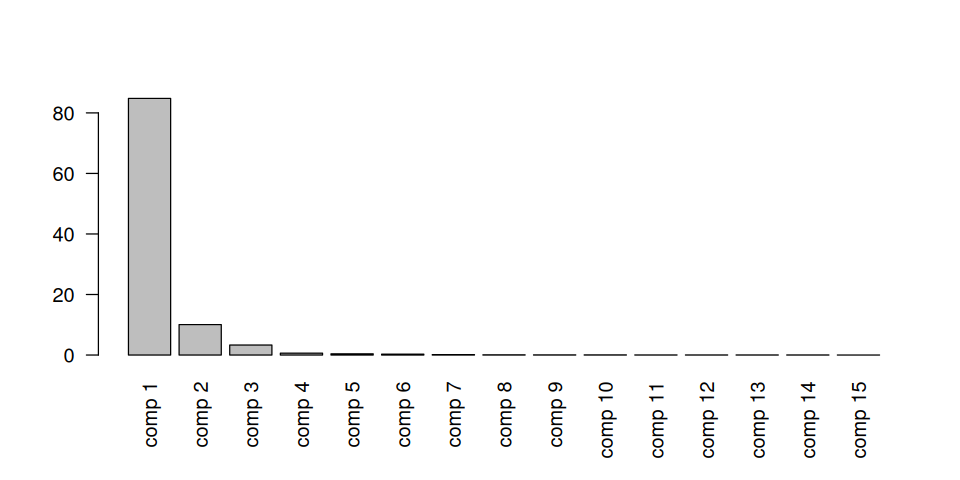

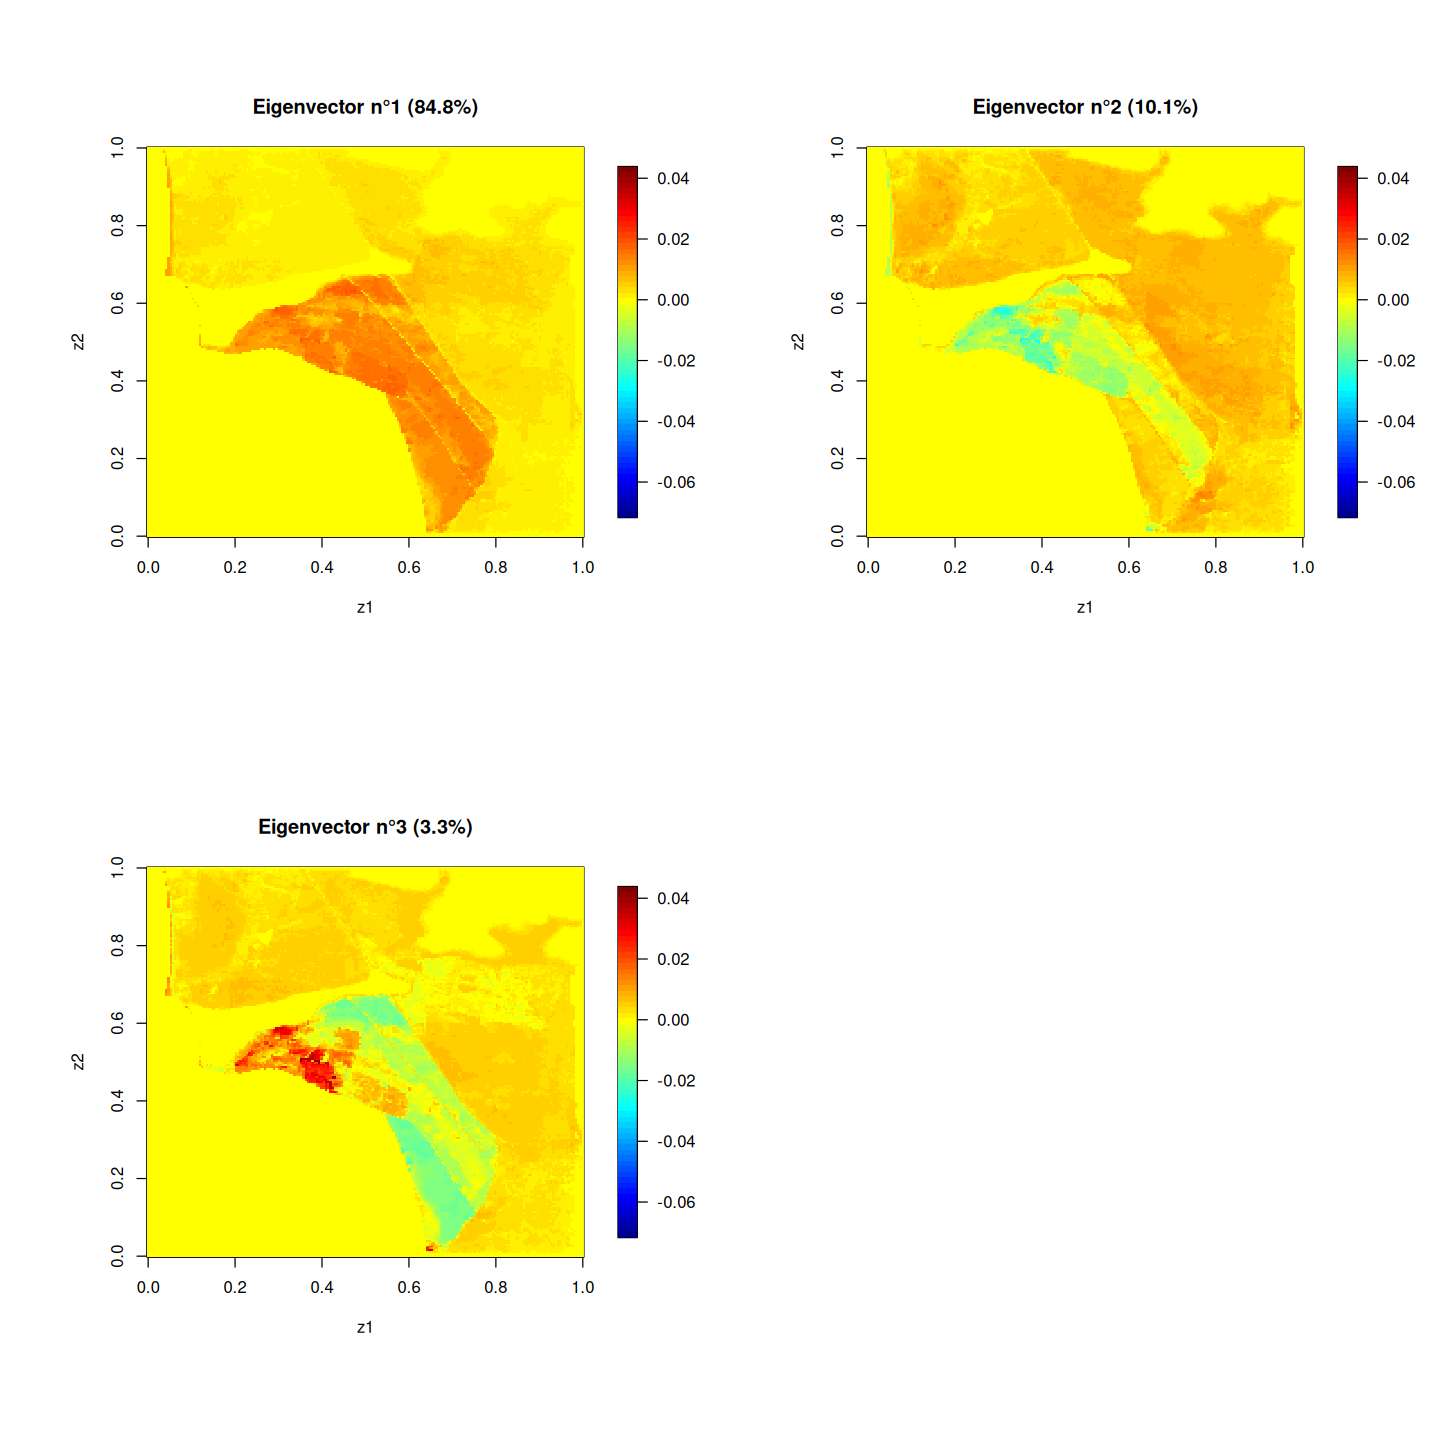

In [14]:
# Question 3
# PCA on trainSet
library(FactoMineR)

resPCA <- PCA(YtrainSet, graph = FALSE,       # PCA on the maps of the training set     # YtrainSet ajouté
              scale.unit = FALSE, ncp = 15)                                             # ncp ajouté

par(mfrow = c(1, 1))
options(repr.plot.width = 8, repr.plot.height = 4)
barplot(resPCA$eig[1:15, 2], las = 2)

# visualization of the first eigenvectors, as maps
par(mfrow = c(2, 2))
options(repr.plot.width = 12, repr.plot.height = 12)
zlim = range(resPCA$svd$V[, 1:4])
for (j in 1:3){
  image.plot(z1, z2, vec2map(resPCA$svd$V[, j]), 
             zlim = zlim,
             main = paste("Eigenvector n°", j, " (", 
                          round(resPCA$eig[j, 2], 1),  "%)", sep = ""),
             graphics.reset = TRUE)
}


[1] 4.782186e-24

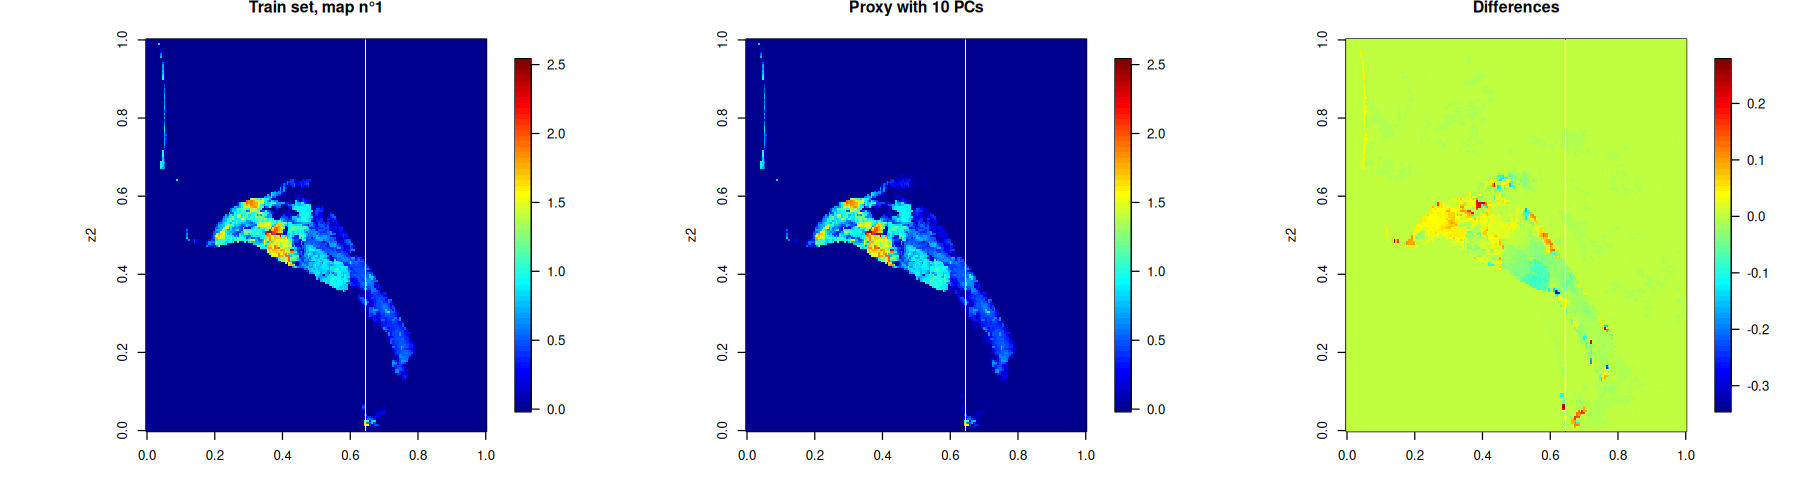

In [15]:
# Question 4
PCAencoder <- function(dataset, PCAmodel){
  # takes a dataset whose rows are vector in R^p and returns the PC coordinates 
  # notice that the vector is first centered and scaled (if scale.unit = TRUE in PCAmodel)
  vect <- scale(dataset, 
                center = PCAmodel$call$centre, 
                scale = PCAmodel$call$ecart.type)
  return(vect %*% PCAmodel$svd$V)
}

# test for PCAencoder
PCcoord <- PCAencoder(YtrainSet, PCAmodel = resPCA)
sum((resPCA$ind$coord - PCcoord)^2)  # should be zero

PCAdecoder <- function(PCcoord, PCAmodel){
  # takes a matrix whose rows are PC coordinates
  # and express it in the original space R^q
  # notice that data are scaled back and centered back
  nPC <- ncol(PCcoord)
  res <- PCcoord %*% t(PCAmodel$svd$V[, 1:nPC])
  for (i in 1:nrow(res)){
    res[i, ] <- res[i, ] * PCAmodel$call$ecart.type + PCAmodel$call$centre
  }
  # here the result should be non-negative
  res <- pmax(res, 0)
  return(res)
}

# compute PC coordinates (apply the PCA encoder)
PCcoord <- PCAencoder(YtrainSet, resPCA)        #
# reconstitute the images from the first nPC coordinates (apply the PCA decoder)
nPC <- 10
YtrainSetProxy <- PCAdecoder(PCcoord[, 1:nPC], resPCA)

# test
par(mfrow = c(1, 3))
options(repr.plot.width = 15, repr.plot.height = 4)
zlim <- range(c(YtrainSet[1, ], YtrainSetProxy[1, ]))
image.plot(z1, z2, zlim = zlim, vec2map(YtrainSet[1, ]), 
           main = "Train set, map n°1", 
           graphics.reset = TRUE)
image.plot(z1, z2, zlim = zlim, vec2map(YtrainSetProxy[1, ]),
           main = paste("Proxy with", nPC, "PCs"), 
           graphics.reset = TRUE)
image.plot(z1, z2, vec2map(YtrainSet[1, ] - YtrainSetProxy[1, ]),
           main = paste("Differences"), 
           graphics.reset = TRUE)


optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 1e-10 1e-10 
  - parameters upper bounds :  1.8125 1.972656 1.964844 1.976562 1.980469 
  - best initial criterion value(s) :  -642.246 -658.1992 -660.8817 -661.9211 -671.1813 -671.5662 -679.334 -690.9619 -698.3868 -715.8961 -719.8468 -733.21 -735.3302 -737.964 -739.7204 -748.3815 -749.2062 -750.5727 -751.4477 -751.6255 -758.6742 -764.3838 -771.9685 -772.8907 -777.846 -778.0218 -783.8604 -784.8817 -787.2627 -787.5572 -790.3741 -790.4163 -790.9774 -791.9388 -795.6629 -796.3674 -796.7202 -800.8269 -800.8763 -802.4713 -806.0966 -807.935 -810.4101 -814.259 -821.6481 -822.3612 -826.8205 -835.7863 -837.3156 -840.903 


* The 50 best values (multistart) obtained are:
 614.2168 614.2168 614.2168 614.2168 614.2168 614.2168 614.2168 614.2168 61

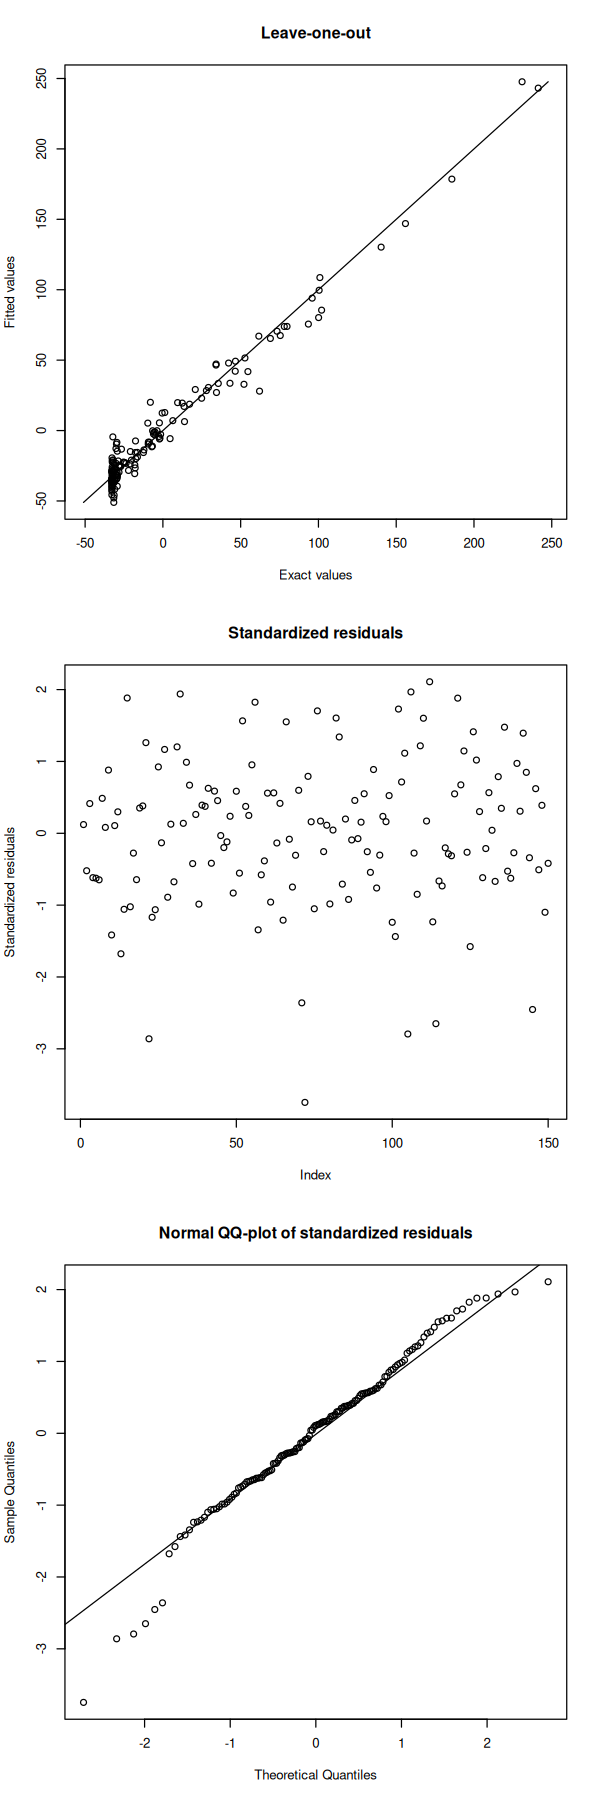

In [21]:
# Question 5
GPlist <- list()  # the GP models for each selected PCsgbgt will be stored in this list

library(DiceKriging)
require(foreach)

# fit a kriging model for the first nPC principal components
require(doParallel)
nCores <- detectCores() - 1
cl <-  makeCluster(nCores) 
registerDoParallel(cl)

nPC <- 10 # just to start: to be increased !!!
for (j in 1:nPC){
  GPlist[[j]] <- km(design = Xtrain, response = resPCA$ind$coord[, j],     # modif sur design et response 
                    multistart = 50)
}

stopCluster(cl)

# print results 
print(GPlist[[1]])  # example for the first GP model

# quality of GP models
options(repr.plot.width = 5, repr.plot.height = 15)
plot(GPlist[[1]])

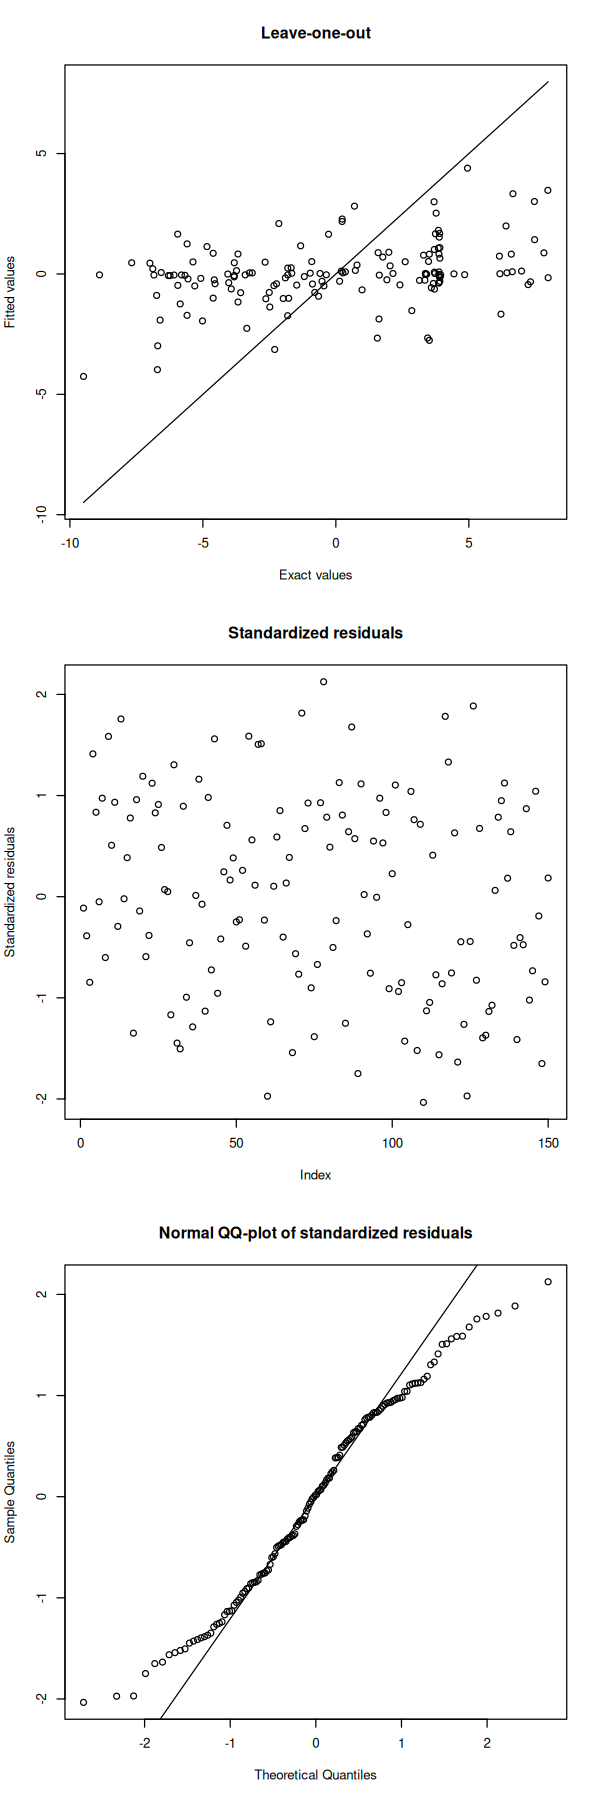

In [50]:
# quality of GP models
options(repr.plot.width = 5, repr.plot.height = 15)
plot(GPlist[[4]])

### **ANSWER :**

The kernel used is matern5_2. We use multistart to avoid getting stuck in local minima. By using a random number of points, the optimiser has a better chance of converging towards the global optimum. Here are the output parameters of the model:

**Covar. coeff.:**
|               | Estimate |
|---------------|----------|
| theta(T)      | 0.5423   |
| theta(S)      | 0.8743   |
| theta(t0)     | 0.2916   |
| theta(tm)     | 1.4821   |
| theta(tM)     | 1.3180   |

Of these coefficients, the smallest have the greatest influence. Here, we can see that the variable t0 is very important and that the variables T and S are of average importance. The variables tm and tM are less important.
The smaller theta is, the more the covariance between xi and xi' (variables with low correlation) will tend towards 0, which implies high variance and therefore high influence. If theta is large, the covariance between xi and xi' (highly correlated variables) will tend towards 1 and the variance will be much smaller, with little explanability.

PCs of order >= 4 imply a worse final prediction, as can be seen from the first plot, where the points are not on the bisector.

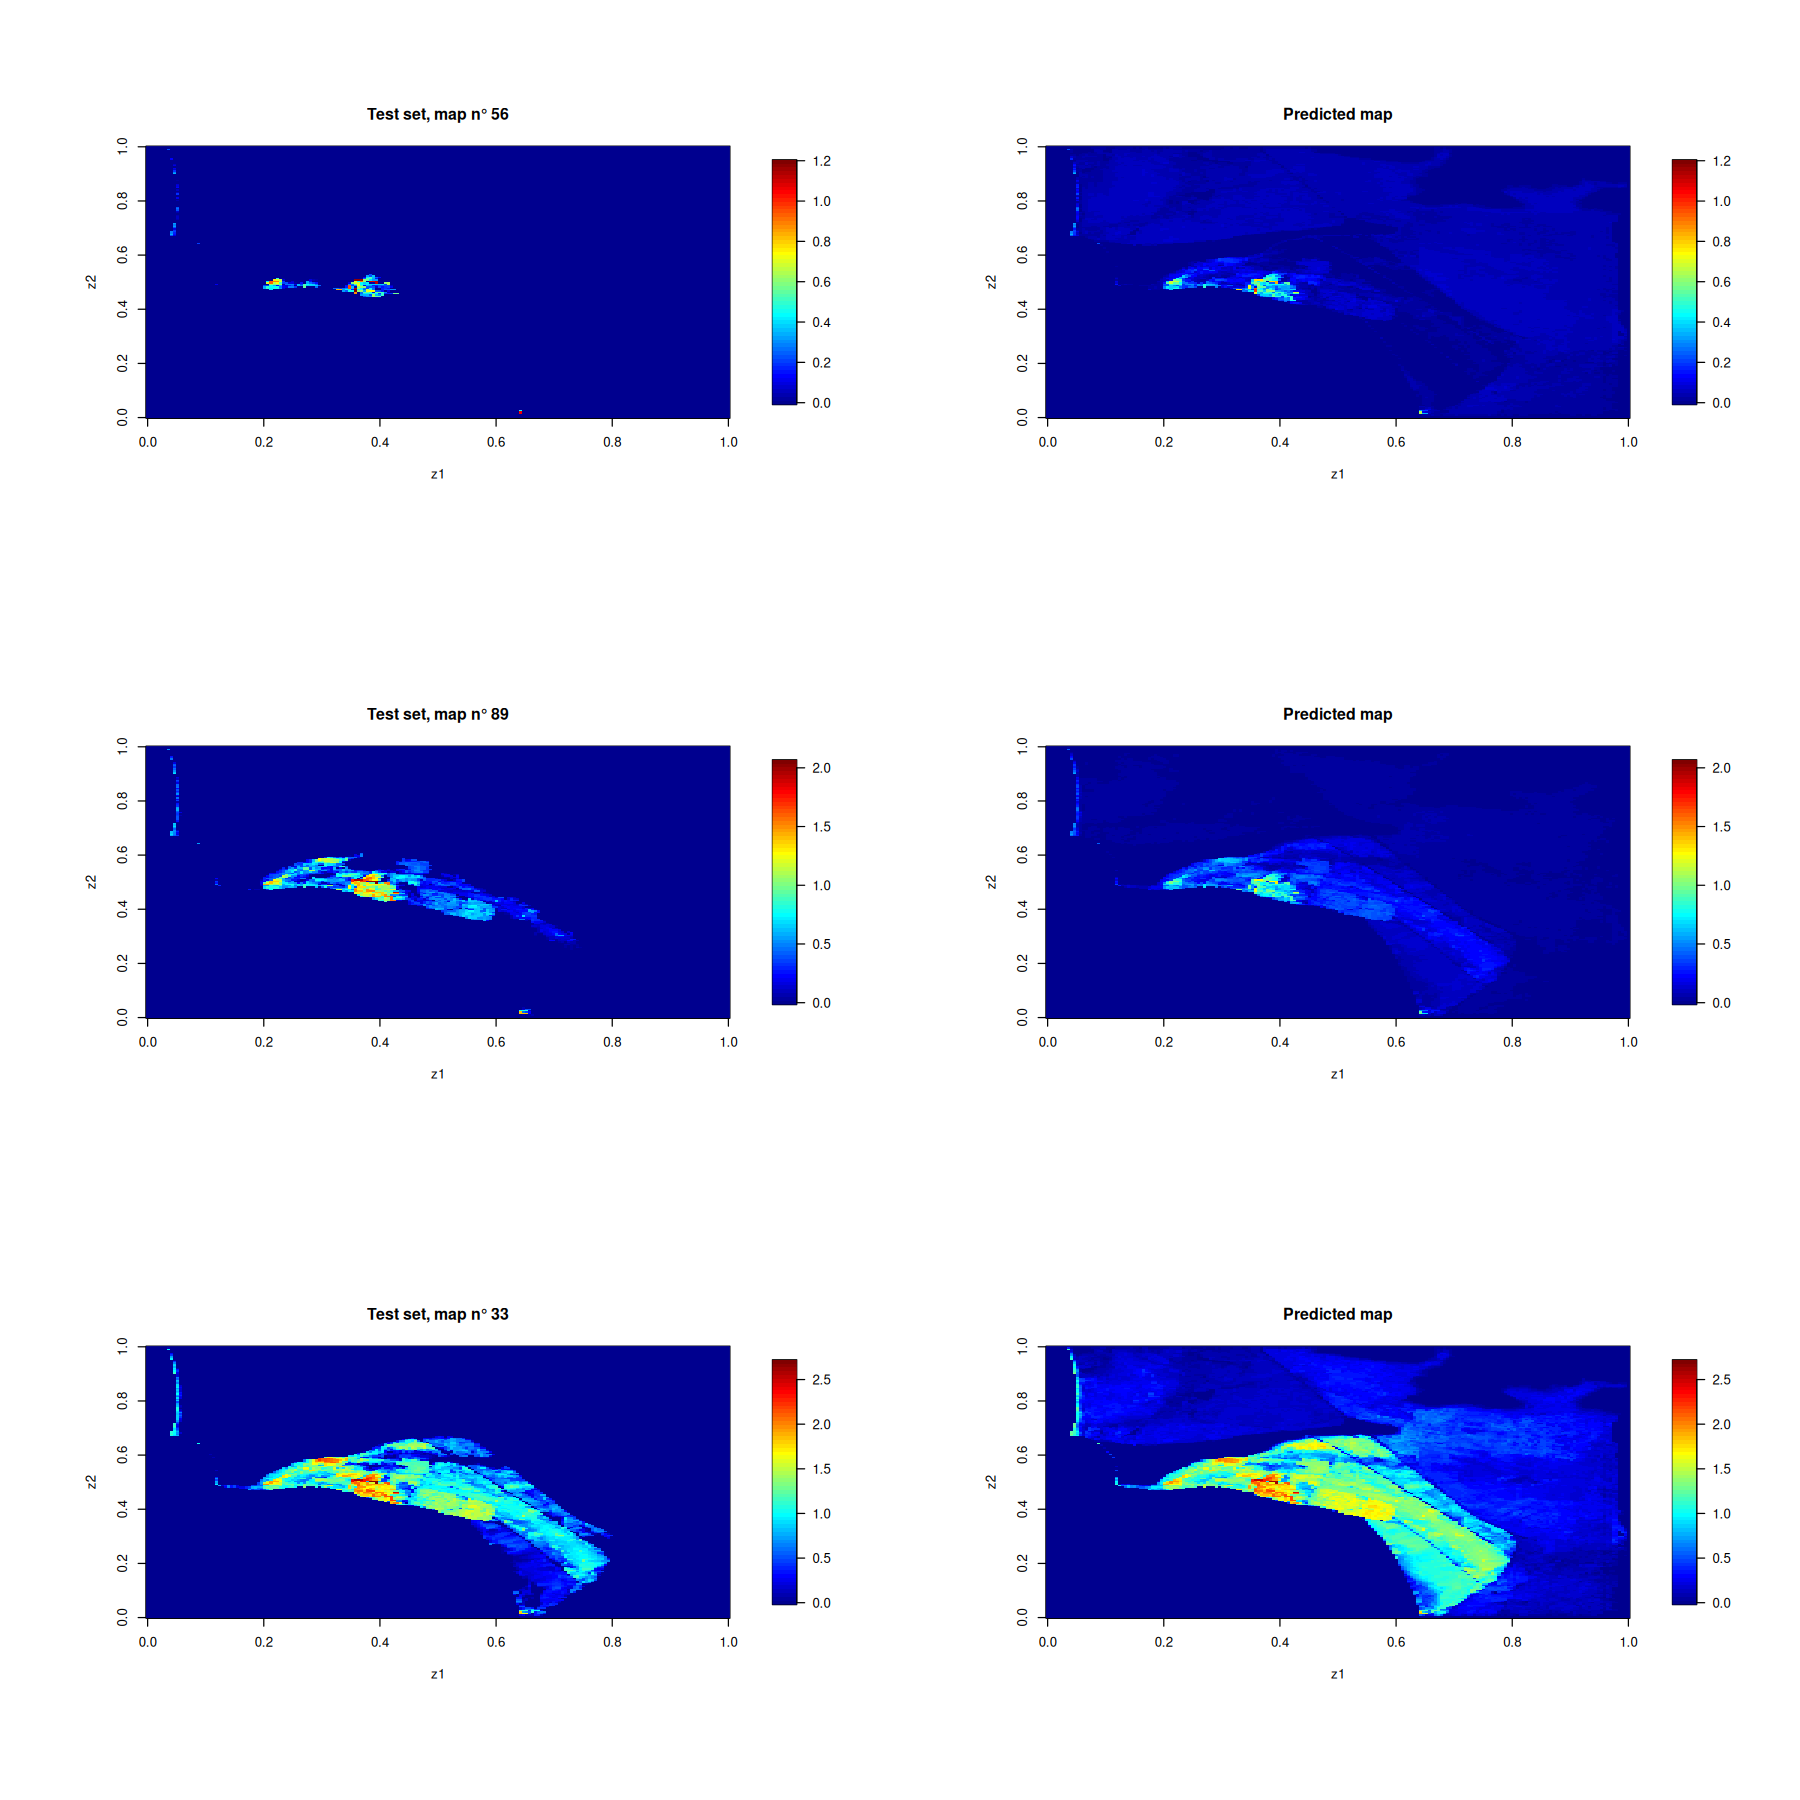

In [51]:
# question 6
# compute predictions
GPpred <- matrix(NA, nrow = nTest, ncol = nPC)
for (j in 1:nPC){
    # prediction for each PC
    GPpred[, j] <- predict(GPlist[[j]], newdata = Xtest,            #
                           checkNames = FALSE, type = "UK")$mean
}

# deduce the prediction on the image with the PCA decoder
YtestSetGPpred <- PCAdecoder(GPpred, resPCA)


# test
par(mfrow = c(3, 2))
options(repr.plot.width = 15, repr.plot.height = 15)
for (i in 1:3){
  j <- sample(1:nTest, 1)
  zlim <- range(c(YtestSet[j, ], YtestSetGPpred[j, ]))
  image.plot(z1, z2, zlim = zlim, vec2map(YtestSet[j, ]), 
             main = paste("Test set, map n°", j),
             graphics.reset = TRUE)
  image.plot(z1, z2, zlim = zlim, vec2map(YtestSetGPpred[j, ]),
             main = "Predicted map", 
             graphics.reset = TRUE)
}

Q2 =  0.9484211 


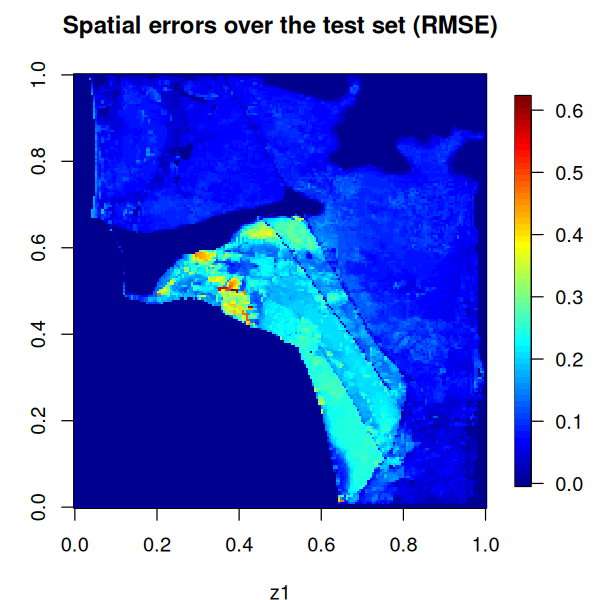

In [52]:
# Question 6 (continued)
# computation of the spatial error 
spatialMSE <- function(obs, pred){
  colMeans((obs - pred)^2)  
}

RMSE <- sqrt(spatialMSE(YtestSet, YtestSetGPpred))
par(mfrow = c(1, 1))
options(repr.plot.width = 5, repr.plot.height = 5)
image.plot(z1, z2, zlim = c(0, max(RMSE)), 
           matrix(RMSE, nrow = nGridx, ncol = nGridy),
           main = "Spatial errors over the test set (RMSE)",
           graphics.reset = TRUE)

Q2 <- function(obs, pred){
  sampleMean <- colMeans(obs) # naive prediction by the sample mean
  Q2num <- mean(spatialMSE(obs, pred))
  Q2denum <- mean(spatialMSE(obs, sampleMean))
  return(1 - Q2num / Q2denum)
}

cat("Q2 = ", Q2(YtestSet, YtestSetGPpred), "\n")


Registered S3 method overwritten by 'sensitivity':
  method    from 
  print.src dplyr



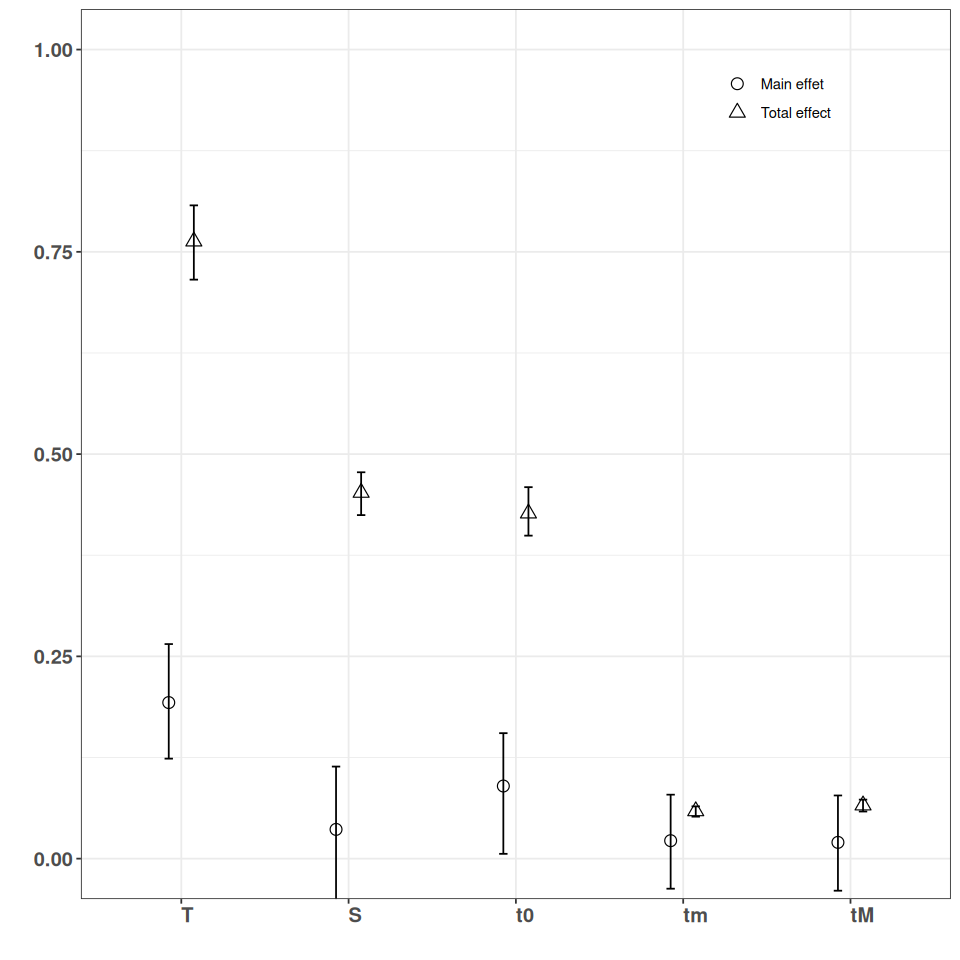

In [53]:
# Question 7
library(sensitivity)
library(ggplot2)

N <- 10000 # size of the simulation sample
d <- ncol(doe)

X1 <- matrix(runif(N * d), nrow = N, ncol = d) # a matrix of size N*d containing simulations from the uniform distribution
X2 <- matrix(runif(N * d), nrow = N, ncol = d) # a second matrix of size N*d containing other (independent) simulations from the uniform distribution

X1 <- data.frame(X1); names(X1) <- names(doe)
X2 <- data.frame(X2); names(X2) <- names(doe)

# GSA on the first principal components
nPC_for_SA <- 2

# Wrapper for sensitivity analysis
krigingMean <- function(Xnew, m){
  predict.km(m, Xnew, "UK", se.compute = FALSE, 
             checkNames = FALSE)$mean
}

SA_GP <- list()
sobolIndexGP <- matrix(NA, nrow = nPC_for_SA, ncol = d)
totalIndexGP <- matrix(NA, nrow = nPC_for_SA, ncol = d)
colnames(sobolIndexGP) <- colnames(totalIndexGP) <- names(doe)

for (j in 1:nPC_for_SA){
  mySA_GP <- soboljansen(model = krigingMean, X1, X2, nboot = 100,    #
                    m = GPlist[[j]])                                  #
  totalIndexGP[j, ] <- mySA_GP$T$original
  sobolIndexGP[j, ] <- mySA_GP$S$original
  SA_GP[[j]] <- mySA_GP
}
options(repr.plot.width = 8, repr.plot.height = 8)
ggplot(SA_GP[[1]])

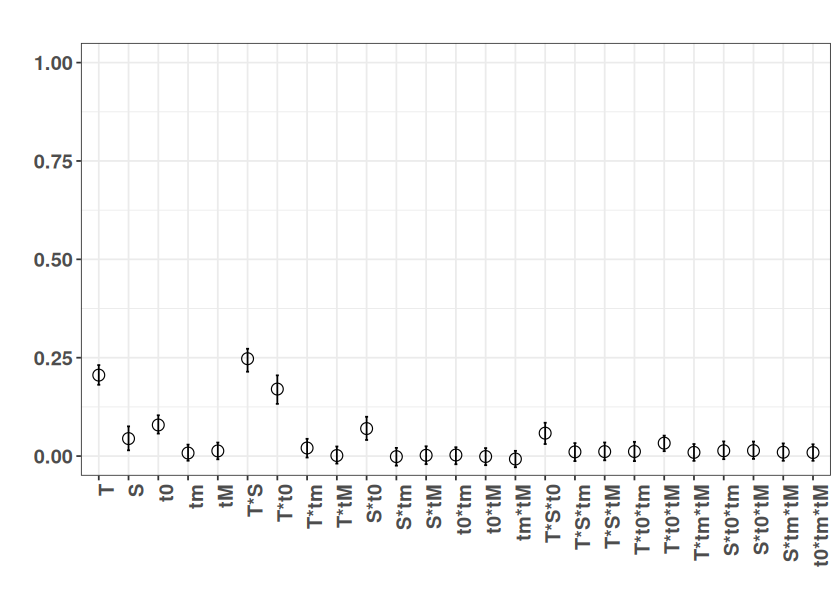

In [54]:
# Question 8
SA2_GP <- list()
order <- 3
sobolIndex2_GP <- matrix(NA, nrow = nPC_for_SA, ncol = 25)

for (j in 1:nPC_for_SA){
  mySA_GP <- sobol(model = krigingMean, X1, X2,order=order, nboot = 100,m = GPlist[[j]])    #
  sobolIndex2_GP[j, ] <- mySA_GP$S$original
  SA2_GP[[j]] <- mySA_GP
}

par(mfrow = c(1, 1))
options(repr.plot.width = 7, repr.plot.height = 5)
ggplot(SA2_GP[[1]])

In [55]:
# question 9
# generalized sensitivity index
eigenvalProp <- resPCA$eig[1:nPC_for_SA, 2]/100   # PCA eigenvalues (percentages)

sobolIndex2_GP_GSI <- ?? # to be deduced from sobolIndex2_GP

colnames(sobolIndex2_GP_GSI) <- rownames(SA2_GP[[1]]$S)
par(mfrow = c(1, 1))
colMain <- "lightgrey"
colTotal <- "blue"
barplot(sobolIndex2_GP_GSI, ylim = c(0, 1), col = colMain, 
        cex.names = 0.6, las = 2)
legend("topright", legend = c("Sobol index"), fill = c(colMain))
print(sum(sobolIndex2_GP_GSI))

ERROR: Error in help.search(c("<-", "colnames(sobolIndex2_GP_GSI)", "rownames(SA2_GP[[1]]$S)": argument ‘pattern’ must be a character string


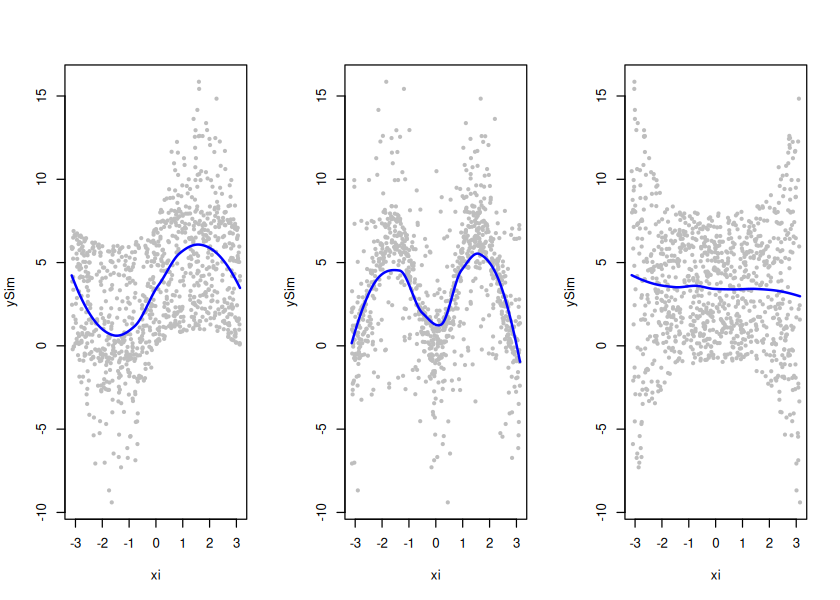

In [60]:
# question 10
N <- 1000

xSim <- matrix(runif(3*N, -pi, pi), N, 3)

ishigamiFun <- function(x){
  sin(x[, 1]) + 7 * sin(x[, 2])^2 + 0.1 * x[, 3]^4 * sin(x[, 1])
}

ySim <- ishigamiFun(xSim)

par(mfrow = c(1, 3))

for (i in 1:3){
    xi <- xSim[, i]
    plot(xi, ySim, cex = 0.5, pch = 19, col = "grey")
    ss <- loess(y ~ xi, data = data.frame(y = ySim, xi = xi)) # estimation of the conditional expectation
    t <- seq(from = min(xi), to = max(xi), length = 200)
    lines(t, predict(ss, t), col = "blue", lwd = 2)
}

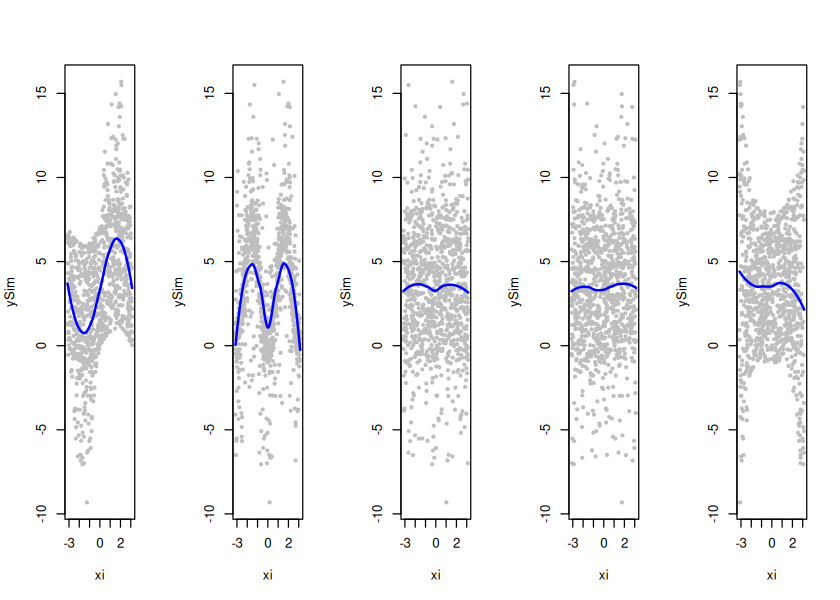

In [61]:
N <- 1000

xSim <- matrix(runif(5*N, -pi, pi), N, 5)

ishigamiFun <- function(x){
  sin(x[, 1]) + 7 * sin(x[, 2])^2 + 0.1 * x[, 5]^4 * sin(x[, 1])
}

ySim <- ishigamiFun(xSim)

par(mfrow = c(1, 5))

for (i in 1:5){
    xi <- xSim[, i]
    plot(xi, ySim, cex = 0.5, pch = 19, col = "grey")
    ss <- loess(y ~ xi, data = data.frame(y = ySim, xi = xi)) # estimation of the conditional expectation
    t <- seq(from = min(xi), to = max(xi), length = 200)
    lines(t, predict(ss, t), col = "blue", lwd = 2)
}

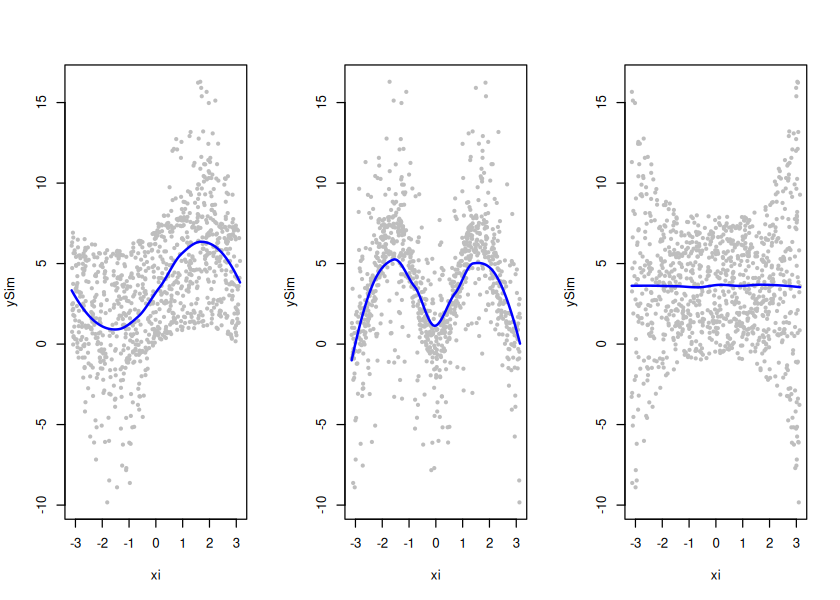

In [ ]:
# representation of main effects on the kriging mean
j <- 1
??